In [97]:
import pandas as pd
from datetime import *
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
rating="AA"
df=pd.read_excel("corp_bval.xlsx",sheet_name=rating)
data=pd.read_excel("template.xlsx",sheet_name="09022020")
data=data.drop(index=84)

In [98]:
mask_corp= (data.Type=="Corporate")
mask_rating=(data.BB_COMPOSITE == rating+"+" )|( data.BB_COMPOSITE == rating) | (data.BB_COMPOSITE == rating+"-")
mask_country=(data.COUNTRY=="US")
dataf=data.loc[mask_rating & mask_corp & mask_country,:]

In [99]:
dataf.INDUSTRY_GROUP.describe()

count         12
unique         5
top       Retail
freq           4
Name: INDUSTRY_GROUP, dtype: object

In [100]:
# mask_ind=(dataf.INDUSTRY_GROUP=="Beverages")
# dataf=dataf.loc[mask_ind,:]
dataf

,CUSIP,BBG,NAME,COUNTRY,INDUSTRY_SECTOR,Type,INDUSTRY_GROUP,TICKER,ISSUE_DT,MATURITY,...,RTG_MOODY,RTG_FITCH,BB_COMPOSITE,RTG_SP_OUTLOOK,RTG_MDY_OUTLOOK,RTG_FITCH_OUTLOOK,RTG_SP_WATCH,RTG_MOODY_WATCH,RTG_FITCH_WATCH,20200902
19,037833AL4,037833AL4 govt,APPLE INC,US,Technology,Corporate,Computers,AAPL,5/3/2013,5/4/2043,...,Aa1,NaN,AA+,STABLE,STABLE,NaN,NaN,NaN,NaN,NaN
20,037833cj7,037833cj7 corp,APPLE INC,US,Technology,Corporate,Computers,AAPL,2/9/2017,2/9/2027,...,Aa1,NaN,AA+,STABLE,STABLE,NaN,NaN,NaN,NaN,NaN
123,3130AEAU4,3130AEAU4 CORP,FEDERAL HOME LOAN BANK,US,Government,Corporate,Sovereign,FHLB,5/10/2018,5/10/2038,...,Aaa,NaN,AA+,NaN,STABLE,NaN,NaN,NaN,NaN,NaN
124,3130AEFL9,3130AEFL9 CORP,FEDERAL HOME LOAN BANK,US,Government,Corporate,Sovereign,FHLB,6/12/2018,6/12/2043,...,Aaa,NaN,AA+,NaN,STABLE,NaN,NaN,NaN,NaN,NaN
125,3133XGAY0,3133XGAY0 CORP,FEDERAL HOME LOAN BANK,US,Government,Corporate,Sovereign,FHLB,7/17/2006,7/15/2036,...,Aaa,NaN,AA+,NaN,STABLE,NaN,NaN,NaN,NaN,NaN
281,742718EB1,742718EB1 corp,PROCTER & GAMBLE CO/THE,US,"Consumer, Non-cyclical",Corporate,Cosmetics/Personal Care,PG,8/13/2013,8/15/2023,...,Aa3,NaN,AA-,STABLE,STABLE,NaN,NaN,NaN,NaN,NaN
320,880591CJ9,880591CJ9 govt,TEN VAL AUTH,US,Utilities,Corporate,Electric,TVA,11/3/1995,11/1/2025,...,Aaa,AAA,AA+,#N/A Field Not Applicable,#N/A Field Not Applicable,#N/A Field Not Applicable,NaN,NaN,NaN,NaN
321,880591DM1,880591DM1 govt,TEN VAL AUTH,US,Utilities,Corporate,Electric,TVA,6/30/2000,5/1/2030,...,Aaa,AAA,AA+,#N/A Field Not Applicable,#N/A Field Not Applicable,#N/A Field Not Applicable,NaN,NaN,NaN,NaN
426,931142CB7,931142CB7 corp,WALMART INC,US,"Consumer, Cyclical",Corporate,Retail,WMT,8/31/2005,9/1/2035,...,Aa2,AA,AA,STABLE,STABLE,STABLE,NaN,NaN,NaN,NaN
427,931142CK7,931142CK7 corp,WALMART INC,US,"Consumer, Cyclical",Corporate,Retail,WMT,8/24/2007,8/15/2037,...,Aa2,AA,AA,STABLE,STABLE,STABLE,NaN,NaN,NaN,NaN


In [101]:
dataf.MATURITY=pd.to_datetime(dataf.MATURITY)
dataf.loc[:,"Tenor"]=pd.to_datetime(dataf.MATURITY).apply(lambda x: ((x-pd.Timestamp(2020, 9, 2)).days/365)//0.05*0.05)
dataf=dataf.loc[dataf.Tenor<=30,:]
yld=dataf.YLD_YTM_MID.values 
tn=dataf.Tenor.values
ticker=dataf.CUSIP.values

year_limit_mask=(dataf.Tenor<=3)
df_year=dataf.loc[year_limit_mask,:]
yld_year=df_year.YLD_YTM_MID.values 
tn_year=df_year.Tenor.values

watch_mask=(dataf.RTG_SP_WATCH=='*-')|(dataf.RTG_MOODY_WATCH=='*-')|(dataf.RTG_FITCH_WATCH=='*-')
df_watch=dataf.loc[watch_mask,:]
yld_watch=df_watch.YLD_YTM_MID.values 
tn_watch=df_watch.Tenor.values


tenor=[3/12,6/12,1,2,3,4,5,6,7,8,9,10,15,20,25,30]
# tenor=[3/12,6/12,1,2,3,4,5,7,8,9,10,15,20,25,30]
yd=df.iloc[:,-2].values
cs = CubicSpline(tenor, yd)
xs = np.arange(3/12, 30, 0.05)//0.05*0.05
yld_dict=dict(zip(np.round(xs,2),cs(xs)))
watch_mask=(dataf.RTG_SP_WATCH=='*-')|(dataf.RTG_MOODY_WATCH=='*-')|(dataf.RTG_FITCH_WATCH=='*-')
dataf.loc[:,"yld_curve"]=dataf.loc[:,"Tenor"].apply(lambda x:yld_dict[round(x,2)])
dataf.loc[:,"Below"]=[x>y for x,y in zip(dataf.yld_curve.values,dataf.YLD_YTM_MID.values)]

below_mask=dataf.Below==True
df_year=dataf.loc[below_mask,:]
yld_below=df_year.YLD_YTM_MID.values 
tn_below=df_year.Tenor.values

C:\Users\Aaron\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\Aaron\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Aaron\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [102]:
total_mask= ~(below_mask|watch_mask|year_limit_mask)
tics=dataf.loc[total_mask,"CUSIP"].values

[Text(0, 0.5, 'YTM'),
 Text(0.5, 0, 'Tenor(year)'),
 Text(0.5, 1.0, 'US AA Financial Composite Yield Curve')]

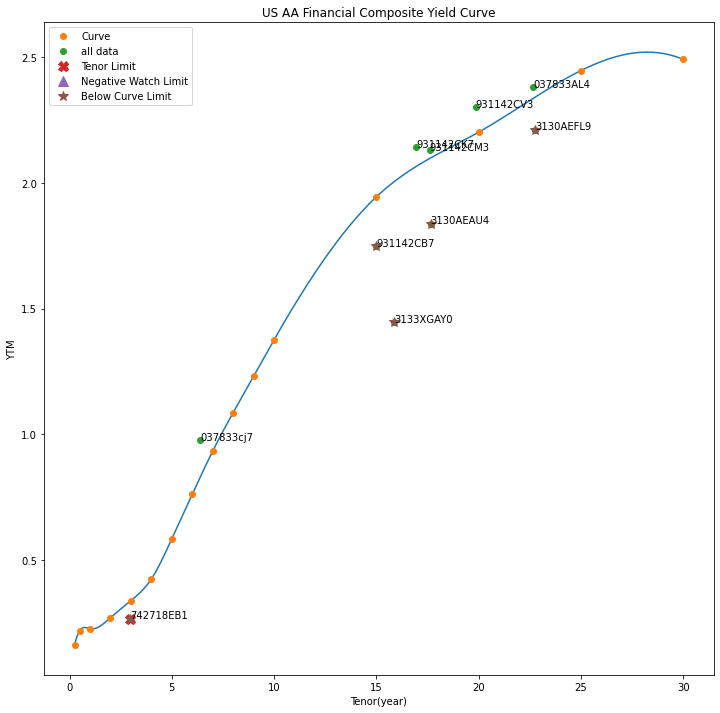

In [103]:
xs = np.arange(3/12, 30, 0.05)
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(xs,cs(xs))
ax.plot(tenor, yd, 'o', label='Curve')
ax.plot(tn, yld, 'o', label='all data')
ax.plot(tn_year, yld_year, 'X',markersize=10, label='Tenor Limit')
ax.plot(tn_watch, yld_watch, '^', markersize=10,label='Negative Watch Limit')
ax.plot(tn_below, yld_below, '*', markersize=10,label='Below Curve Limit')
for i, txt in enumerate(ticker):
    ax.annotate(txt, (tn[i], yld[i]))
ax.legend(loc="upper left")
ax.set(title="US {} Financial Composite Yield Curve".format(rating),
        ylabel="YTM",
      xlabel="Tenor(year)")

In [104]:
d0902=pd.read_excel("template.xlsx",sheet_name="09022020").drop(index=84)
d0917=pd.read_excel("template.xlsx",sheet_name="09172020").drop(index=84)
d0930=pd.read_excel("template.xlsx",sheet_name="09302020").drop(index=84)
d1007=pd.read_excel("template.xlsx",sheet_name="10072020").drop(index=84)
d1014=pd.read_excel("template.xlsx",sheet_name="10142020").drop(index=84)
d1022=pd.read_excel("template.xlsx",sheet_name="10222020").drop(index=84)
d1028=pd.read_excel("template.xlsx",sheet_name="10282020").drop(index=84)
d1104=pd.read_excel("template.xlsx",sheet_name="11042020").drop(index=84)
d1112=pd.read_excel("template.xlsx",sheet_name="11122020").drop(index=84)
d1130=pd.read_excel("template.xlsx",sheet_name="11302020").drop(index=84)
temp=d0902.loc[:,["CUSIP","Market_mid_price"]]
for ch in [d0917,d0930,d1007,d1014,d1022,d1028,d1104,d1112,d1130]:
    a=ch.loc[:,["Market_mid_price"]]
    temp=pd.concat([temp,a],axis=1)
temp=temp.set_index("CUSIP")
tp=temp.copy()
tp.columns=["09022020","09172020","09302020","10072020","10142020","10222020","10282020","11042020","11122020","11302020"]
tp

,09022020,09172020,09302020,10072020,10142020,10222020,10282020,11042020,11122020,11302020
CUSIP,,,,,,,,,,
00103yaf8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
001546au4,86.3220,87.0600,87.4285,91.9520,91.8045,93.8715,94.5045,94.7810,94.6725,98.6480
00165cad6,31.4830,32.5350,23.6385,13.9040,14.6780,7.7615,6.7110,5.7065,10.4575,17.7135
00206RAZ5,103.9200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00287YAM1,122.0505,120.8010,118.5335,118.8725,121.7850,118.3540,118.4490,120.9345,122.4110,126.8260
...,...,...,...,...,...,...,...,...,...,...
50048MCV0,101.8590,101.6920,101.3425,100.6435,101.1215,100.0120,100.6085,100.5985,100.0575,100.5505
XS0683568223,121.3440,121.7565,120.9675,120.8105,121.1345,121.1660,121.4645,121.4095,121.3560,121.7425
UV4264304,105.5110,105.4270,105.3345,105.1755,105.2075,105.0935,105.1265,105.1155,104.9490,105.0190


In [105]:
em=temp.loc[tics,:].dropna()
em

,Market_mid_price,Market_mid_price,Market_mid_price,Market_mid_price,Market_mid_price,Market_mid_price,Market_mid_price,Market_mid_price,Market_mid_price,Market_mid_price
CUSIP,,,,,,,,,,
037833AL4,125.6275,125.9120,124.2235,124.1735,125.3625,122.5380,115.0105,125.9670,125.1920,128.8655
037833cj7,114.7575,114.6555,114.3090,113.9840,114.3210,113.5325,111.3810,113.9420,113.3720,114.0295
931142CK7,161.6290,161.3605,159.4215,158.3940,160.2540,158.9655,153.3245,161.7040,161.2030,163.8305
931142CM3,159.5190,159.7430,158.7770,157.0400,158.9455,157.3765,152.2610,160.6040,159.9580,161.6750
931142CV3,140.8150,139.8055,138.1990,136.9455,139.9525,137.5475,132.7880,139.4925,140.0975,142.6305


In [106]:
em.iloc[:,-1]-em.iloc[:,0]

CUSIP
037833AL4    3.2380
037833cj7   -0.7280
931142CK7    2.2015
931142CM3    2.1560
931142CV3    1.8155
Name: Market_mid_price, dtype: float64

In [107]:
em.index.to_list()

['037833AL4', '037833cj7', '931142CK7', '931142CM3', '931142CV3']

In [108]:
corp_BBB=['035229cf8',
 '035242an6',
 '101137AE7',
 '11043haa6',
 '233835AQ0',
 '233851CB8',
 '25272KAR4',
 '31428XBB1',
 '369604BG7',
 '369604BH5',
 '36962G3P7',
 '36962G4B7',
 '36962GXZ2',
 '36966tedo',
 '36966THU9',
 '37045VAE0',
 '37045VAH3',
 '378272AH1',
 '378272AL2',
 '91913YAS9',
 '92343VAF1',
 'aq3361807',
 'EC4232897']
   
corp_A=['438506as6',
 '63946BAF7',
 '63946BAJ9',
 '68389XAM7']#corp A
corp_AA=['037833AL4', '037833cj7', '931142CK7', '931142CM3', '931142CV3']#corp AA
   
corp_BB=['US022249AU09',
 '345397XL2',
 '432891ak5',
 '668027at2',
 '680665ak2',
 '717265al6',
 '747262aw3',
 '86765lam9',
 '87264aat2',
 '98310wan8',
 '984121CB7',
 '98877DAC9']
fin_AA=['084664BU4', '09247XAN1', '09247XAL5']
fin_A=['06051GFF1',
 '06051GFS3',
 '06051GFX2',
 '172967HT1',
 '172967JP7',
 '38141GCU6',
 '38141GGM0',
 '38141GVM3',
 '61746BDZ6',
 '949746RF0',
 '94974BFY1',
 '94974BGL8']
fin_BBB=['172967KA8', '29444uar7', '38141GFD1']

In [109]:
selected_cusip=corp_BB+corp_AA+corp_A+corp_BBB+fin_AA+fin_A+fin_BBB


In [110]:
data_temp=pd.read_excel("template.xlsx",sheet_name="09022020").set_index("CUSIP")
data_temp.MATURITY=pd.to_datetime(data_temp.MATURITY)
data_temp.loc[:,"Tenor"]=pd.to_datetime(data_temp.MATURITY).apply(lambda x: ((x-pd.Timestamp(2020, 9, 2)).days/365)//0.05*0.05)
# data=data.drop(index=84)
data_temp

,BBG,NAME,COUNTRY,INDUSTRY_SECTOR,Type,INDUSTRY_GROUP,TICKER,ISSUE_DT,MATURITY,CPN,...,RTG_FITCH,BB_COMPOSITE,RTG_SP_OUTLOOK,RTG_MDY_OUTLOOK,RTG_FITCH_OUTLOOK,RTG_SP_WATCH,RTG_MOODY_WATCH,RTG_FITCH_WATCH,20200902,Tenor
CUSIP,,,,,,,,,,,,,,,,,,,,,
00103yaf8,00103yaf8 corp,RED OAK POWER LLC,US,Utilities,Corporate,Electric,REDOAK,9/18/2000,2029-11-30,9.200,...,NaN,NR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.20
001546au4,001546au4 corp,AK STEEL CORP,US,Basic Materials,Corporate,Iron/Steel,AKS,3/23/2017,2027-03-15,7.000,...,CCC+,CCC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.50
00165cad6,00165cad6 corp,AMC ENTERTAINMENT HLDGS,US,"Consumer, Cyclical",Corporate,Entertainment,AMC,7/6/2017,2027-05-15,6.125,...,WD,CC+,NaN,NEG,NaN,*-,NaN,NaN,NaN,6.70
00206RAZ5,00206RAZ5 corp,AT&T INC,US,Communications,Corporate,Telecommunications,T,8/18/2011,2021-08-15,3.875,...,WD,NR,STABLE,STABLE,STABLE,NaN,NaN,NaN,NaN,0.95
00287YAM1,00287YAM1 corp,ABBVIE INC,US,"Consumer, Non-cyclical",Corporate,Pharmaceuticals,ABBV,8/5/2013,2042-11-06,4.400,...,NaN,BBB,STABLE,STABLE,NaN,NaN,NaN,NaN,NaN,22.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50048MCV0,50048MCV0 corp,KOMMUNALBANKEN AS,NO,Government,Government,Sovereign,KBN,6/16/2020,2030-06-14,1.125,...,NaN,AAA,STABLE,STABLE,NaN,NaN,NaN,NaN,NaN,9.75
XS0683568223,XS0683568223 corp,IMPERIAL BRANDS FIN PLC,EN,"Consumer, Non-cyclical",Corporate,Agriculture,IMBLN,9/26/2011,2026-09-28,5.500,...,BBB,BBB-,NaN,STABLE,NaN,NaN,NaN,NaN,NaN,6.05
UV4264304,UV4264304 corp,KFW,GE,Financial,Financial,Banks,KFW,8/7/2015,2023-08-07,2.125,...,AAAu,AAA,STABLE,STABLE,STABLE,NaN,NaN,NaN,NaN,2.90


In [111]:
temp=data_temp.loc[selected_cusip,:]
temp

,BBG,NAME,COUNTRY,INDUSTRY_SECTOR,Type,INDUSTRY_GROUP,TICKER,ISSUE_DT,MATURITY,CPN,...,RTG_FITCH,BB_COMPOSITE,RTG_SP_OUTLOOK,RTG_MDY_OUTLOOK,RTG_FITCH_OUTLOOK,RTG_SP_WATCH,RTG_MOODY_WATCH,RTG_FITCH_WATCH,20200902,Tenor
CUSIP,,,,,,,,,,,,,,,,,,,,,
US022249AU09,US022249AU09 corp,HOWMET AEROSPACE INC,US,Industrial,Corporate,Aerospace/Defense,HWM,1/27/1998,2028-01-15,6.750,...,BBB-,BB+,NaN,NEG,STABLE,NaN,NaN,NaN,NaN,7.35
345397XL2,345397XL2 corp,FORD MOTOR CREDIT CO LLC,US,"Consumer, Cyclical",Corporate,Auto Manufacturers,F,8/4/2015,2025-08-04,4.134,...,BB+,BB,NEG,NEG,NEG,NaN,NaN,NaN,NaN,4.90
432891ak5,432891ak5 corp,HILTON WORLDWIDE FIN LLC,US,"Consumer, Cyclical",Corporate,Lodging,HLT,8/7/2017,2027-04-01,4.875,...,NaN,BB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.55
668027at2,668027at2 corp,NORTHWESTERN BELL TELEPH,US,Communications,Corporate,Telecommunications,CTL,5/9/1990,2030-05-01,7.750,...,BB+,BB+,NaN,STABLE,NaN,NaN,NaN,NaN,NaN,9.65
680665ak2,680665ak2 corp,OLIN CORP,US,Basic Materials,Corporate,Chemicals,OLN,1/19/2018,2030-02-01,5.000,...,NaN,BB-,NEG,NEG,NaN,NaN,NaN,NaN,NaN,9.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94974BFY1,94974BFY1 corp,WELLS FARGO & COMPANY,US,Financial,Financial,Banks,WFC,6/3/2014,2026-06-03,4.100,...,A-,A-,STABLE,NEG,NEG,NaN,NaN,NaN,NaN,5.75
94974BGL8,94974BGL8 corp,WELLS FARGO & COMPANY,US,Financial,Financial,Banks,WFC,7/22/2015,2027-07-22,4.300,...,A-,A-,STABLE,NEG,NEG,NaN,NaN,NaN,NaN,6.85
172967KA8,172967KA8 corp,CITIGROUP INC,US,Financial,Financial,Banks,C,9/29/2015,2027-09-29,4.450,...,BBB+,BBB+,STABLE,STABLE,NEG,NaN,NaN,NaN,NaN,7.05


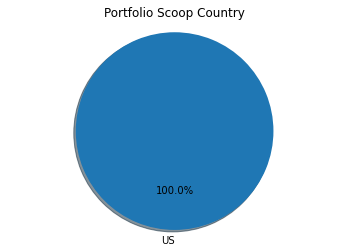

In [112]:
import matplotlib.pyplot as plt
labels,sizes=np.unique(temp.COUNTRY,return_counts=True)
fig1, ax1 = plt.subplots()
ax1.pie(sizes,  labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set(title="Portfolio Scoop Country")
plt.show()

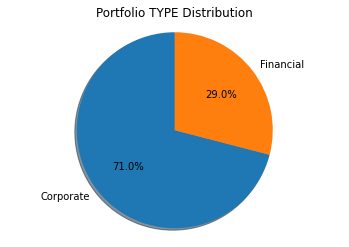

In [113]:
import matplotlib.pyplot as plt
labels,sizes=np.unique(temp.Type,return_counts=True)
fig1, ax1 = plt.subplots()
ax1.pie(sizes,  labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set(title="Portfolio TYPE Distribution")
plt.show()

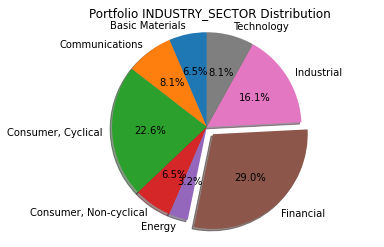

In [114]:
import matplotlib.pyplot as plt
labels,sizes=np.unique(temp.INDUSTRY_SECTOR,return_counts=True)
fig1, ax1 = plt.subplots()
explode=np.zeros(len(sizes))
explode[np.argmax(sizes)]=0.1
ax1.pie(sizes,  labels=labels,explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set(title="Portfolio INDUSTRY_SECTOR Distribution")
plt.show()

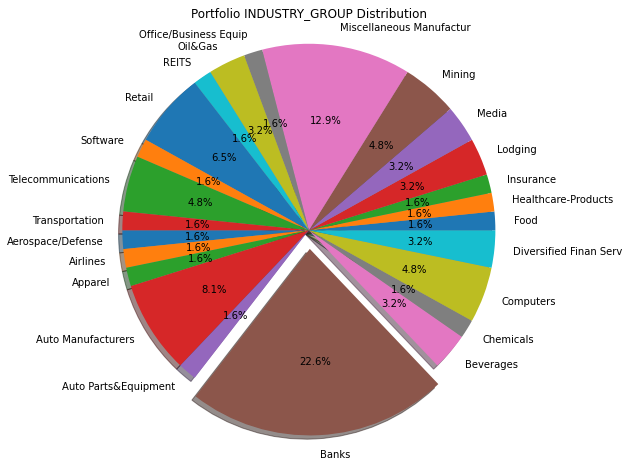

In [115]:
labels,sizes=np.unique(temp.INDUSTRY_GROUP,return_counts=True)
fig1, ax1 = plt.subplots(figsize=(8, 8))
explode=np.zeros(len(sizes))
explode[np.argmax(sizes)]=0.1
ax1.pie(sizes,  labels=labels,explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=180)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set(title="Portfolio INDUSTRY_GROUP Distribution")
# ax1.legend()
plt.show()

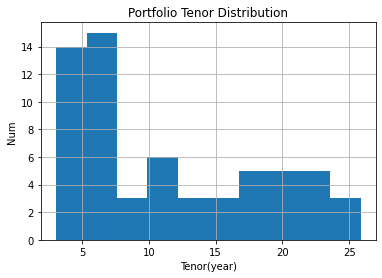

In [116]:
fig1, ax1 = plt.subplots()

# ax1.legend(loc="upper right")
ax1.set(title="Portfolio Tenor Distribution",
        ylabel="Num",
      xlabel="Tenor(year)")
temp.Tenor.hist()

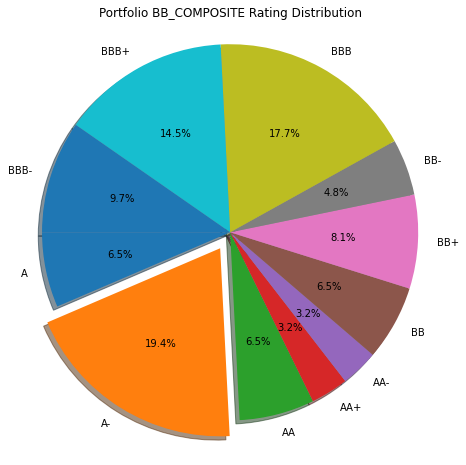

In [117]:
labels,sizes=np.unique(temp.BB_COMPOSITE,return_counts=True)
fig1, ax1 = plt.subplots(figsize=(8, 8))
explode=np.zeros(len(sizes))
explode[np.argmax(sizes)]=0.1
ax1.pie(sizes,  labels=labels,explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=180)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set(title="Portfolio BB_COMPOSITE Rating Distribution")
# ax1.legend()
plt.show()

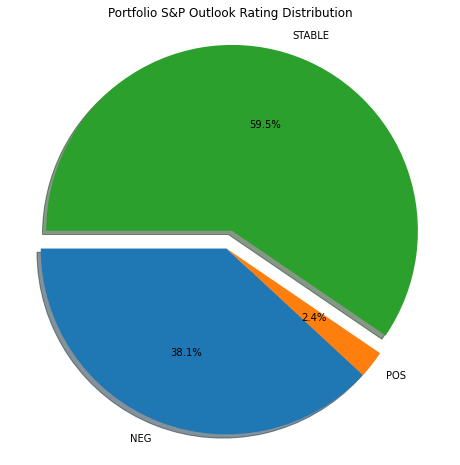

In [118]:
labels,sizes=np.unique(temp.RTG_SP_OUTLOOK.dropna(),return_counts=True)
fig1, ax1 = plt.subplots(figsize=(8, 8))
explode=np.zeros(len(sizes))
explode[np.argmax(sizes)]=0.1
ax1.pie(sizes,  labels=labels,explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=180)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set(title="Portfolio S&P Outlook Rating Distribution")
# ax1.legend()
plt.show()

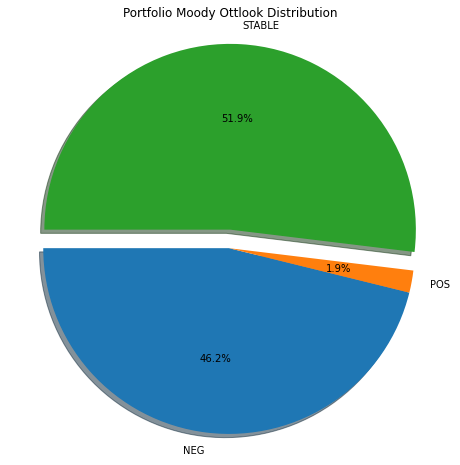

In [119]:
labels,sizes=np.unique(temp.RTG_MDY_OUTLOOK.dropna(),return_counts=True)
fig1, ax1 = plt.subplots(figsize=(8, 8))
explode=np.zeros(len(sizes))
explode[np.argmax(sizes)]=0.1
ax1.pie(sizes,  labels=labels,explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=180)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set(title="Portfolio Moody Ottlook Distribution")
# ax1.legend()
plt.show()

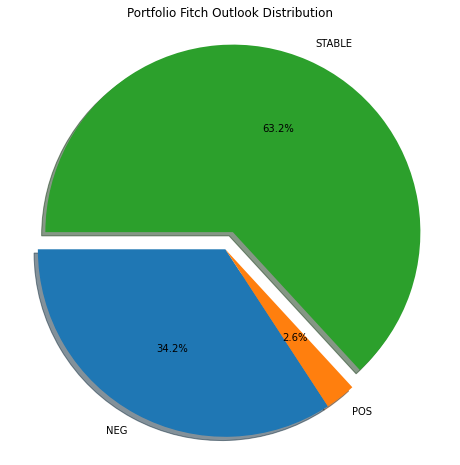

In [120]:
labels,sizes=np.unique(temp.RTG_FITCH_OUTLOOK.dropna(),return_counts=True)
fig1, ax1 = plt.subplots(figsize=(8, 8))
explode=np.zeros(len(sizes))
explode[np.argmax(sizes)]=0.1
ax1.pie(sizes,  labels=labels,explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=180)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set(title="Portfolio Fitch Outlook Distribution")
# ax1.legend()
plt.show()

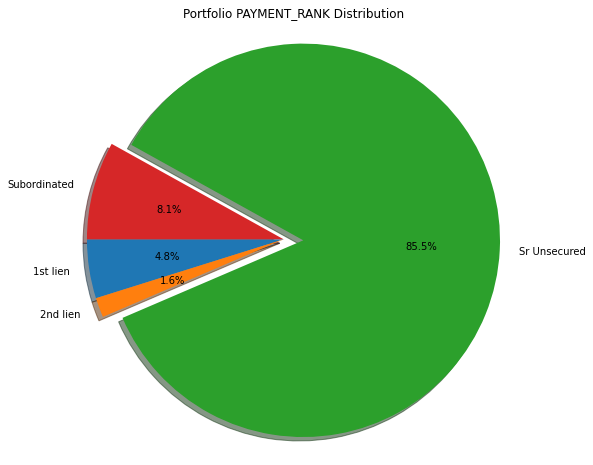

In [121]:
labels,sizes=np.unique(temp.PAYMENT_RANK,return_counts=True)
fig1, ax1 = plt.subplots(figsize=(8, 8))
explode=np.zeros(len(sizes))
explode[np.argmax(sizes)]=0.1
ax1.pie(sizes,  labels=labels,explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=180)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set(title="Portfolio PAYMENT_RANK Distribution")
# ax1.legend()
plt.show()

In [122]:
temp.loc[:,"Money"]=10000000
for i in range(len(temp.index)):
    if temp.index[i] in corp_A:
        temp.loc[temp.index[i],"Money"]=8750000
    if temp.index[i] in corp_BBB:
        temp.loc[temp.index[i],"Money"]=5000000

In [125]:
temp_money=temp.copy()
temp_money

,BBG,NAME,COUNTRY,INDUSTRY_SECTOR,Type,INDUSTRY_GROUP,TICKER,ISSUE_DT,MATURITY,CPN,...,BB_COMPOSITE,RTG_SP_OUTLOOK,RTG_MDY_OUTLOOK,RTG_FITCH_OUTLOOK,RTG_SP_WATCH,RTG_MOODY_WATCH,RTG_FITCH_WATCH,20200902,Tenor,Money
CUSIP,,,,,,,,,,,,,,,,,,,,,
US022249AU09,US022249AU09 corp,HOWMET AEROSPACE INC,US,Industrial,Corporate,Aerospace/Defense,HWM,1/27/1998,2028-01-15,6.750,...,BB+,NaN,NEG,STABLE,NaN,NaN,NaN,NaN,7.35,10000000
345397XL2,345397XL2 corp,FORD MOTOR CREDIT CO LLC,US,"Consumer, Cyclical",Corporate,Auto Manufacturers,F,8/4/2015,2025-08-04,4.134,...,BB,NEG,NEG,NEG,NaN,NaN,NaN,NaN,4.90,10000000
432891ak5,432891ak5 corp,HILTON WORLDWIDE FIN LLC,US,"Consumer, Cyclical",Corporate,Lodging,HLT,8/7/2017,2027-04-01,4.875,...,BB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.55,10000000
668027at2,668027at2 corp,NORTHWESTERN BELL TELEPH,US,Communications,Corporate,Telecommunications,CTL,5/9/1990,2030-05-01,7.750,...,BB+,NaN,STABLE,NaN,NaN,NaN,NaN,NaN,9.65,10000000
680665ak2,680665ak2 corp,OLIN CORP,US,Basic Materials,Corporate,Chemicals,OLN,1/19/2018,2030-02-01,5.000,...,BB-,NEG,NEG,NaN,NaN,NaN,NaN,NaN,9.40,10000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94974BFY1,94974BFY1 corp,WELLS FARGO & COMPANY,US,Financial,Financial,Banks,WFC,6/3/2014,2026-06-03,4.100,...,A-,STABLE,NEG,NEG,NaN,NaN,NaN,NaN,5.75,10000000
94974BGL8,94974BGL8 corp,WELLS FARGO & COMPANY,US,Financial,Financial,Banks,WFC,7/22/2015,2027-07-22,4.300,...,A-,STABLE,NEG,NEG,NaN,NaN,NaN,NaN,6.85,10000000
172967KA8,172967KA8 corp,CITIGROUP INC,US,Financial,Financial,Banks,C,9/29/2015,2027-09-29,4.450,...,BBB+,STABLE,STABLE,NEG,NaN,NaN,NaN,NaN,7.05,10000000


In [ ]:
temp.to_excel("output.xlsx") 

In [31]:
tp

,09022020,09172020,09302020,10072020,10142020,10222020,10282020,11042020,11122020,11302020
CUSIP,,,,,,,,,,
00103yaf8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
001546au4,86.3220,87.0600,87.4285,91.9520,91.8045,93.8715,94.5045,94.7810,94.6725,98.6480
00165cad6,31.4830,32.5350,23.6385,13.9040,14.6780,7.7615,6.7110,5.7065,10.4575,17.7135
00206RAZ5,103.9200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00287YAM1,122.0505,120.8010,118.5335,118.8725,121.7850,118.3540,118.4490,120.9345,122.4110,126.8260
...,...,...,...,...,...,...,...,...,...,...
50048MCV0,101.8590,101.6920,101.3425,100.6435,101.1215,100.0120,100.6085,100.5985,100.0575,100.5505
XS0683568223,121.3440,121.7565,120.9675,120.8105,121.1345,121.1660,121.4645,121.4095,121.3560,121.7425
UV4264304,105.5110,105.4270,105.3345,105.1755,105.2075,105.0935,105.1265,105.1155,104.9490,105.0190


In [35]:
ts=tp.loc[selected_cusip,:].T
ts

CUSIP,US022249AU09,345397XL2,432891ak5,668027at2,680665ak2,717265al6,747262aw3,86765lam9,87264aat2,98310wan8,...,38141GCU6,38141GGM0,38141GVM3,61746BDZ6,949746RF0,94974BFY1,94974BGL8,172967KA8,29444uar7,38141GFD1
09022020,115.7300,100.9215,103.3605,111.7415,97.4785,136.6960,100.0015,106.1155,108.4660,103.6195,...,143.4770,154.4055,111.0815,115.2460,138.8575,113.6035,116.0185,116.9935,109.5675,148.8190
09172020,112.6620,99.8785,102.9685,109.9930,95.5115,138.3905,100.0215,104.2155,107.1335,103.4780,...,143.0985,153.4455,110.7200,114.7665,139.5035,113.5540,115.4060,116.7715,109.1380,148.4445
09302020,110.3265,98.8065,102.3200,111.6660,94.7205,136.7185,100.1665,102.8340,106.9795,102.5455,...,142.0465,149.8485,110.1790,113.8160,136.0625,112.7200,114.5090,115.9930,109.0910,144.4705
10072020,112.4105,100.2660,103.3325,109.9745,97.8430,135.8940,99.5385,103.7290,107.3555,102.5990,...,143.1095,149.5890,110.1340,113.9615,135.5420,113.4630,115.0300,116.2010,109.2360,146.0425
10142020,114.3750,101.2915,103.7590,111.4175,99.9355,138.1315,99.5170,105.1555,107.4990,104.4010,...,144.1480,152.1830,110.6260,114.2365,137.9775,113.7280,115.4860,116.5480,109.2120,147.6740
10222020,114.3130,101.0170,103.6695,111.2530,99.8850,138.8995,99.6690,104.6845,107.3865,104.7215,...,142.9860,150.1830,110.4905,113.9480,135.5020,113.4450,115.1235,115.9995,109.2155,145.7590
10282020,113.5755,100.0785,101.8520,109.1825,100.4855,139.6310,99.0505,102.5775,106.7935,104.7270,...,149.6085,160.2010,111.9845,113.8800,136.2400,113.9350,115.4225,115.9880,109.1150,150.0540
11042020,115.8040,102.2695,103.4450,110.4380,101.9345,141.1225,99.9155,105.4865,107.6960,105.6025,...,144.9720,153.8195,110.4305,114.4150,137.2800,114.0355,115.9885,116.3865,109.0930,149.8190
11122020,117.6540,102.6395,103.7685,114.9890,105.1750,140.9935,100.2535,106.2955,107.8075,108.4650,...,144.1545,154.5075,110.4235,114.2875,138.3410,113.5940,115.2840,116.4560,109.0550,149.7125
11302020,119.3035,103.9450,104.3610,115.5905,104.9570,138.3035,101.4860,108.0115,107.2365,110.3245,...,145.3940,157.7075,110.4735,114.4915,144.3725,115.0290,116.6975,117.3410,109.0070,153.3355


In [39]:
ts.pct_change()

CUSIP,US022249AU09,345397XL2,432891ak5,668027at2,680665ak2,717265al6,747262aw3,86765lam9,87264aat2,98310wan8,...,38141GCU6,38141GGM0,38141GVM3,61746BDZ6,949746RF0,94974BFY1,94974BGL8,172967KA8,29444uar7,38141GFD1
09022020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09172020,-0.026510,-0.010335,-0.003793,-0.015648,-0.020179,0.012396,0.000200,-0.017905,-0.012285,-0.001366,...,-0.002638,-0.006217,-0.003254,-0.004161,0.004652,-0.000436,-0.005279,-0.001898,-0.003920,-0.002516
09302020,-0.020730,-0.010733,-0.006298,0.015210,-0.008282,-0.012082,0.001450,-0.013256,-0.001437,-0.009012,...,-0.007352,-0.023442,-0.004886,-0.008282,-0.024666,-0.007345,-0.007773,-0.006667,-0.000431,-0.026771
10072020,0.018889,0.014771,0.009895,-0.015148,0.032965,-0.006031,-0.006270,0.008703,0.003515,0.000522,...,0.007483,-0.001732,-0.000408,0.001278,-0.003825,0.006592,0.004550,0.001793,0.001329,0.010881
10142020,0.017476,0.010228,0.004127,0.013121,0.021386,0.016465,-0.000216,0.013752,0.001337,0.017564,...,0.007257,0.017341,0.004467,0.002413,0.017969,0.002336,0.003964,0.002986,-0.000220,0.011171
10222020,-0.000542,-0.002710,-0.000863,-0.001476,-0.000505,0.005560,0.001527,-0.004479,-0.001047,0.003070,...,-0.008061,-0.013142,-0.001225,-0.002525,-0.017941,-0.002488,-0.003139,-0.004706,0.000032,-0.012968
10282020,-0.006452,-0.009291,-0.017532,-0.018611,0.006012,0.005266,-0.006206,-0.020127,-0.005522,0.000053,...,0.046316,0.066705,0.013522,-0.000597,0.005446,0.004319,0.002597,-0.000099,-0.000920,0.029466
11042020,0.019621,0.021893,0.015640,0.011499,0.014420,0.010682,0.008733,0.028359,0.008451,0.008360,...,-0.030991,-0.039834,-0.013877,0.004698,0.007634,0.000882,0.004904,0.003436,-0.000202,-0.001566
11122020,0.015975,0.003618,0.003127,0.041209,0.031790,-0.000914,0.003383,0.007669,0.001035,0.027106,...,-0.005639,0.004473,-0.000063,-0.001114,0.007729,-0.003872,-0.006074,0.000597,-0.000348,-0.000711
11302020,0.014020,0.012719,0.005710,0.005231,-0.002073,-0.019079,0.012294,0.016144,-0.005296,0.017144,...,0.008598,0.020711,0.000453,0.001785,0.043599,0.012633,0.012261,0.007599,-0.000440,0.024200


No handles with labels found to put in legend.


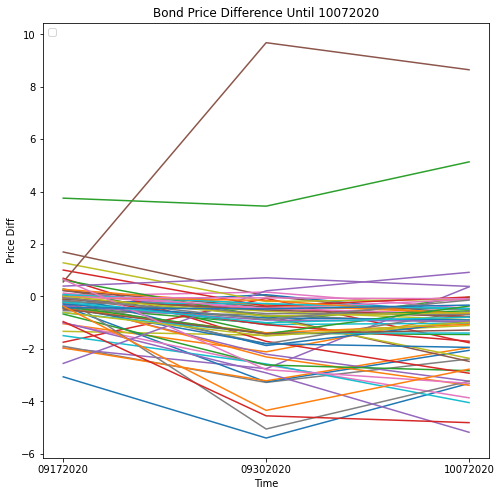

In [70]:
fig1, ax1 = plt.subplots(figsize=(8, 8))

ax1.set(title="Bond Price Difference Until 10072020",
        ylabel="Price Diff",
      xlabel="Time")
ax1.plot(ts.loc[["09022020","09172020","09302020","10072020"],:].diff().cumsum())

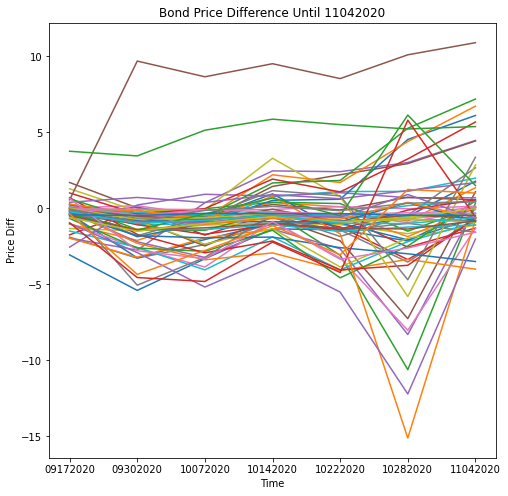

In [74]:
fig1, ax1 = plt.subplots(figsize=(8, 8))
# ["09022020","09172020","09302020","10072020","10142020","10222020","10282020","11042020","11122020","11302020"]
ax1.set(title="Bond Price Difference Until 11042020",
        ylabel="Price Diff",
      xlabel="Time")
ax1.plot(ts.loc[["09022020","09172020","09302020","10072020","10142020","10222020","10282020","11042020"],:].diff().cumsum())

In [53]:
ts.diff().cumsum().T.head(60)
# .loc["11302020",:]

,09022020,09172020,09302020,10072020,10142020,10222020,10282020,11042020,11122020,11302020
CUSIP,,,,,,,,,,
US022249AU09,NaN,-3.0680,-5.4035,-3.3195,-1.3550,-1.4170,-2.1545,0.0740,1.9240,3.5735
345397XL2,NaN,-1.0430,-2.1150,-0.6555,0.3700,0.0955,-0.8430,1.3480,1.7180,3.0235
432891ak5,NaN,-0.3920,-1.0405,-0.0280,0.3985,0.3090,-1.5085,0.0845,0.4080,1.0005
668027at2,NaN,-1.7485,-0.0755,-1.7670,-0.3240,-0.4885,-2.5590,-1.3035,3.2475,3.8490
680665ak2,NaN,-1.9670,-2.7580,0.3645,2.4570,2.4065,3.0070,4.4560,7.6965,7.4785
717265al6,NaN,1.6945,0.0225,-0.8020,1.4355,2.2035,2.9350,4.4265,4.2975,1.6075
747262aw3,NaN,0.0200,0.1650,-0.4630,-0.4845,-0.3325,-0.9510,-0.0860,0.2520,1.4845
86765lam9,NaN,-1.9000,-3.2815,-2.3865,-0.9600,-1.4310,-3.5380,-0.6290,0.1800,1.8960
87264aat2,NaN,-1.3325,-1.4865,-1.1105,-0.9670,-1.0795,-1.6725,-0.7700,-0.6585,-1.2295


In [77]:
c=ts.loc[["09022020","09172020","09302020","10072020"],:].diff().cumsum().T.loc["084664BU4",:]
c.to_excel("1007.xlsx")
c
#1007

09022020       NaN
09172020   -0.9965
09302020   -2.9170
10072020   -5.1835
Name: 084664BU4, dtype: float64

In [78]:
b=ts.loc[["09022020","09172020","09302020","10072020","10142020","10222020","10282020","11042020"],"035229cf8"].diff().cumsum()
b.to_excel("1104.xlsx")
b
#1104

09022020       NaN
09172020   -0.2170
09302020   -2.3090
10072020   -3.3900
10142020   -2.9365
10222020   -4.0995
10282020   -3.3630
11042020   -4.0065
Name: 035229cf8, dtype: float64

In [ ]:
ts.loc[["09022020","09172020","09302020","10072020"],:].diff().cumsum().T.loc["084664BU4",:]


In [79]:
ts

CUSIP,US022249AU09,345397XL2,432891ak5,668027at2,680665ak2,717265al6,747262aw3,86765lam9,87264aat2,98310wan8,...,38141GCU6,38141GGM0,38141GVM3,61746BDZ6,949746RF0,94974BFY1,94974BGL8,172967KA8,29444uar7,38141GFD1
09022020,115.7300,100.9215,103.3605,111.7415,97.4785,136.6960,100.0015,106.1155,108.4660,103.6195,...,143.4770,154.4055,111.0815,115.2460,138.8575,113.6035,116.0185,116.9935,109.5675,148.8190
09172020,112.6620,99.8785,102.9685,109.9930,95.5115,138.3905,100.0215,104.2155,107.1335,103.4780,...,143.0985,153.4455,110.7200,114.7665,139.5035,113.5540,115.4060,116.7715,109.1380,148.4445
09302020,110.3265,98.8065,102.3200,111.6660,94.7205,136.7185,100.1665,102.8340,106.9795,102.5455,...,142.0465,149.8485,110.1790,113.8160,136.0625,112.7200,114.5090,115.9930,109.0910,144.4705
10072020,112.4105,100.2660,103.3325,109.9745,97.8430,135.8940,99.5385,103.7290,107.3555,102.5990,...,143.1095,149.5890,110.1340,113.9615,135.5420,113.4630,115.0300,116.2010,109.2360,146.0425
10142020,114.3750,101.2915,103.7590,111.4175,99.9355,138.1315,99.5170,105.1555,107.4990,104.4010,...,144.1480,152.1830,110.6260,114.2365,137.9775,113.7280,115.4860,116.5480,109.2120,147.6740
10222020,114.3130,101.0170,103.6695,111.2530,99.8850,138.8995,99.6690,104.6845,107.3865,104.7215,...,142.9860,150.1830,110.4905,113.9480,135.5020,113.4450,115.1235,115.9995,109.2155,145.7590
10282020,113.5755,100.0785,101.8520,109.1825,100.4855,139.6310,99.0505,102.5775,106.7935,104.7270,...,149.6085,160.2010,111.9845,113.8800,136.2400,113.9350,115.4225,115.9880,109.1150,150.0540
11042020,115.8040,102.2695,103.4450,110.4380,101.9345,141.1225,99.9155,105.4865,107.6960,105.6025,...,144.9720,153.8195,110.4305,114.4150,137.2800,114.0355,115.9885,116.3865,109.0930,149.8190
11122020,117.6540,102.6395,103.7685,114.9890,105.1750,140.9935,100.2535,106.2955,107.8075,108.4650,...,144.1545,154.5075,110.4235,114.2875,138.3410,113.5940,115.2840,116.4560,109.0550,149.7125
11302020,119.3035,103.9450,104.3610,115.5905,104.9570,138.3035,101.4860,108.0115,107.2365,110.3245,...,145.3940,157.7075,110.4735,114.4915,144.3725,115.0290,116.6975,117.3410,109.0070,153.3355


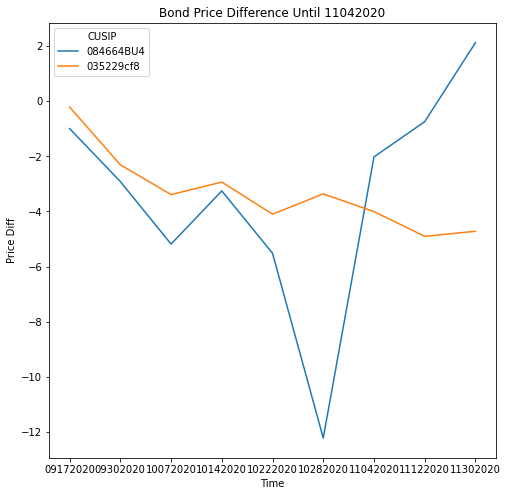

In [87]:
fig1, ax1 = plt.subplots(figsize=(8, 8))
# ["09022020","09172020","09302020","10072020","10142020","10222020","10282020","11042020","11122020","11302020"]
ax1.set(title="Bond Price Difference Until 11042020",
        ylabel="Price Diff",
      xlabel="Time")
ts.loc[:,["084664BU4","035229cf8"]].diff().cumsum().plot(ax=ax1)

In [88]:
ts.loc[:,["084664BU4","035229cf8"]].diff().cumsum()

CUSIP,084664BU4,035229cf8
09022020,NaN,NaN
09172020,-0.9965,-0.2170
09302020,-2.9170,-2.3090
10072020,-5.1835,-3.3900
10142020,-3.2555,-2.9365
10222020,-5.5165,-4.0995
10282020,-12.2145,-3.3630
11042020,-2.0230,-4.0065
11122020,-0.7465,-4.9025
11302020,2.1170,-4.7195


In [90]:
data_temp.loc["035229cf8",:]

BBG                                035229cf8 corp
NAME                       ANHEUSER-BUSCH COS LLC
COUNTRY                                        US
INDUSTRY_SECTOR            Consumer, Non-cyclical
Type                                    Corporate
INDUSTRY_GROUP                          Beverages
TICKER                                      ABIBB
ISSUE_DT                                10/5/2000
MATURITY                      2030-10-01 00:00:00
CPN                                          7.55
CPN_FREQ                                        2
CPN_TYP                                     FIXED
YLD_YTM_MID                               2.63179
Libor_Spread                              242.312
Market_mid_price                          143.274
RISK                                      10.9651
STOCHASTIC_OAS_BID_CNVX                  0.706271
DAYS_TO_NEXT_COUPON                            27
NXT_CPN_DT                              10/1/2020
PREV_CPN_DT                              4/1/2020


In [139]:
ts.loc["09022020",:]

CUSIP
US022249AU09    115.7300
345397XL2       100.9215
432891ak5       103.3605
668027at2       111.7415
680665ak2        97.4785
                  ...   
94974BFY1       113.6035
94974BGL8       116.0185
172967KA8       116.9935
29444uar7       109.5675
38141GFD1       148.8190
Name: 09022020, Length: 62, dtype: float64

In [158]:
pnl=ts-ts.loc['09022020',:].values.squeeze()
# pnl=pnl.reset_index()
pnl

CUSIP,US022249AU09,345397XL2,432891ak5,668027at2,680665ak2,717265al6,747262aw3,86765lam9,87264aat2,98310wan8,...,38141GCU6,38141GGM0,38141GVM3,61746BDZ6,949746RF0,94974BFY1,94974BGL8,172967KA8,29444uar7,38141GFD1
09022020,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
09172020,-3.0680,-1.0430,-0.3920,-1.7485,-1.9670,1.6945,0.0200,-1.9000,-1.3325,-0.1415,...,-0.3785,-0.9600,-0.3615,-0.4795,0.6460,-0.0495,-0.6125,-0.2220,-0.4295,-0.3745
09302020,-5.4035,-2.1150,-1.0405,-0.0755,-2.7580,0.0225,0.1650,-3.2815,-1.4865,-1.0740,...,-1.4305,-4.5570,-0.9025,-1.4300,-2.7950,-0.8835,-1.5095,-1.0005,-0.4765,-4.3485
10072020,-3.3195,-0.6555,-0.0280,-1.7670,0.3645,-0.8020,-0.4630,-2.3865,-1.1105,-1.0205,...,-0.3675,-4.8165,-0.9475,-1.2845,-3.3155,-0.1405,-0.9885,-0.7925,-0.3315,-2.7765
10142020,-1.3550,0.3700,0.3985,-0.3240,2.4570,1.4355,-0.4845,-0.9600,-0.9670,0.7815,...,0.6710,-2.2225,-0.4555,-1.0095,-0.8800,0.1245,-0.5325,-0.4455,-0.3555,-1.1450
10222020,-1.4170,0.0955,0.3090,-0.4885,2.4065,2.2035,-0.3325,-1.4310,-1.0795,1.1020,...,-0.4910,-4.2225,-0.5910,-1.2980,-3.3555,-0.1585,-0.8950,-0.9940,-0.3520,-3.0600
10282020,-2.1545,-0.8430,-1.5085,-2.5590,3.0070,2.9350,-0.9510,-3.5380,-1.6725,1.1075,...,6.1315,5.7955,0.9030,-1.3660,-2.6175,0.3315,-0.5960,-1.0055,-0.4525,1.2350
11042020,0.0740,1.3480,0.0845,-1.3035,4.4560,4.4265,-0.0860,-0.6290,-0.7700,1.9830,...,1.4950,-0.5860,-0.6510,-0.8310,-1.5775,0.4320,-0.0300,-0.6070,-0.4745,1.0000
11122020,1.9240,1.7180,0.4080,3.2475,7.6965,4.2975,0.2520,0.1800,-0.6585,4.8455,...,0.6775,0.1020,-0.6580,-0.9585,-0.5165,-0.0095,-0.7345,-0.5375,-0.5125,0.8935
11302020,3.5735,3.0235,1.0005,3.8490,7.4785,1.6075,1.4845,1.8960,-1.2295,6.7050,...,1.9170,3.3020,-0.6080,-0.7545,5.5150,1.4255,0.6790,0.3475,-0.5605,4.5165


In [160]:
notional

CUSIP
US022249AU09    8.640802e+06
345397XL2       9.908691e+06
432891ak5       9.674876e+06
668027at2       8.949227e+06
680665ak2       1.025867e+07
                    ...     
94974BFY1       8.802546e+06
94974BGL8       8.619315e+06
172967KA8       8.547483e+06
29444uar7       9.126794e+06
38141GFD1       6.719572e+06
Length: 62, dtype: float64

In [159]:
notional=temp_money.Money/ts.loc["09022020",:]*100
mtm=pnl*notional.values/100
mtm

CUSIP,US022249AU09,345397XL2,432891ak5,668027at2,680665ak2,717265al6,747262aw3,86765lam9,87264aat2,98310wan8,...,38141GCU6,38141GGM0,38141GVM3,61746BDZ6,949746RF0,94974BFY1,94974BGL8,172967KA8,29444uar7,38141GFD1
09022020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
09172020,-265099.801262,-103347.651392,-37925.513131,-156477.226456,-201788.086604,123961.198572,1999.970000,-179050.185882,-122849.556543,-13655.730823,...,-26380.534859,-62173.951057,-32543.672889,-41606.650122,46522.514088,-4357.260120,-52793.304516,-18975.413164,-39199.580167,-25164.797506
09302020,-466905.728852,-209568.823293,-100667.082686,-6756.666055,-282934.185487,1645.988178,16499.752504,-309238.518407,-137047.554072,-103648.444550,...,-99702.391324,-295131.973926,-81246.652233,-124082.397654,-201285.490521,-77770.491226,-130108.560273,-85517.571489,-43489.173341,-292200.592666
10072020,-286831.417956,-64951.472184,-2708.965224,-158132.833370,37392.860990,-58670.334172,-46299.305510,-224896.457162,-102382.313352,-98485.323708,...,-25613.861455,-311938.370071,-85297.731846,-111457.230620,-238769.962011,-12367.576703,-85201.929003,-67738.806002,-30255.322062,-186568.919291
10142020,-117082.865290,36662.158212,38554.380058,-28995.494064,252055.581487,105014.045766,-48449.273261,-90467.462341,-89152.361109,75420.167053,...,46767.077650,-143939.173151,-41005.928080,-87595.231071,-63374.322597,10959.169392,-45897.852498,-38079.038579,-32445.752618,-76939.100518
10222020,-122440.162447,9462.800295,29895.366218,-43716.971761,246874.951912,161197.108913,-33249.501257,-134853.061051,-99524.274888,106350.638635,...,-34221.512856,-273468.237854,-53204.178914,-112628.637870,-241650.613039,-13952.034929,-77142.869456,-84961.985068,-32126.314829,-205618.906188
10282020,-186166.076212,-83530.268575,-145945.501425,-229010.707750,308478.279826,214710.013461,-95098.573521,-333410.293501,-154195.784854,106881.426758,...,427350.725203,375342.847243,81291.664229,-118529.059577,-188502.601588,29180.438983,-51371.117537,-85944.945659,-41298.742784,82986.715406
11042020,6394.193381,133569.160189,8175.270050,-116653.168250,457126.443267,323820.740914,-8599.871002,-59275.035221,-70989.987646,191373.245383,...,104197.885375,-37952.015958,-58605.618397,-72106.624091,-113605.674883,38026.997408,-2585.794507,-51883.224282,-43306.637461,67195.720976
11122020,166249.027910,170231.318401,39473.493259,290626.132636,789558.723206,314383.742026,25199.622006,16962.649189,-60710.268656,467624.337118,...,47220.111934,6605.982300,-59235.786337,-83169.914791,-37196.406388,-836.241841,-63308.868844,-45942.723314,-46774.819175,60039.376692
11302020,308779.054696,299589.284741,96797.132367,344455.730413,767194.817319,117596.710950,148447.773283,178673.238123,-113353.493261,647078.976447,...,133610.265060,213852.485825,-54734.586767,-65468.649671,397169.760366,125480.288900,58525.149006,29702.504840,-51155.680288,303489.473790


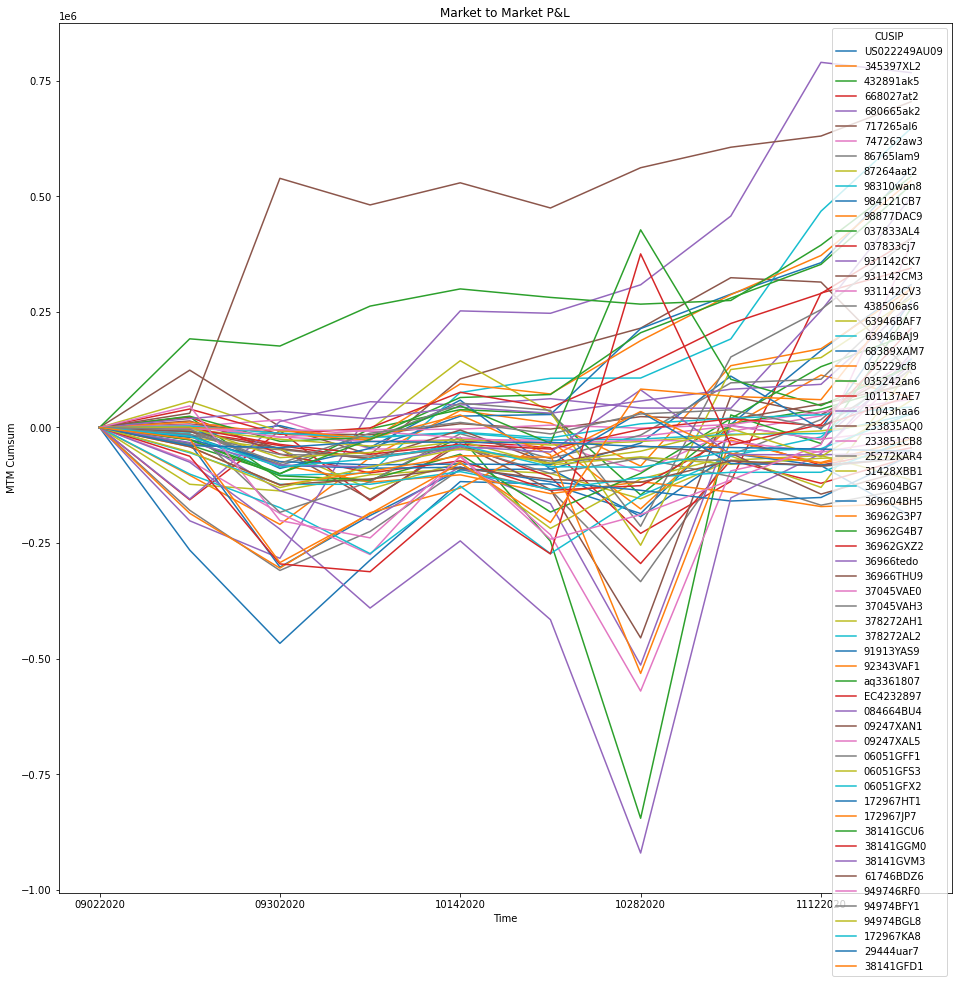

In [182]:
fig1, ax1 = plt.subplots(figsize=(16, 16))
# ["09022020","09172020","09302020","10072020","10142020","10222020","10282020","11042020","11122020","11302020"]
ax1.set(title="Market to Market P&L",
        ylabel="MTM Cumsum",
      xlabel="Time")
# ax1.legend(loc="upper left")

mtm.plot(ax=ax1)

In [161]:
mtm_pnl=mtm.T.sum()
mtm_pnl

09022020    0.000000e+00
09172020   -1.710938e+06
09302020   -5.266479e+06
10072020   -4.807502e+06
10142020   -6.052799e+05
10222020   -3.386815e+06
10282020   -4.533895e+06
11042020    1.999708e+06
11122020    3.811083e+06
11302020    9.803748e+06
dtype: float64

In [165]:
daily_accrual=temp_money.CPN*notional/36000
daily_accrual

CUSIP
US022249AU09    1620.150350
345397XL2       1137.848063
432891ak5       1310.139431
668027at2       1926.569607
680665ak2       1424.815615
                   ...     
94974BFY1       1002.512149
94974BGL8       1029.529294
172967KA8       1056.563921
29444uar7       1362.681046
38141GFD1       1259.919768
Length: 62, dtype: float64

In [168]:
da=ts.copy()
da

CUSIP,US022249AU09,345397XL2,432891ak5,668027at2,680665ak2,717265al6,747262aw3,86765lam9,87264aat2,98310wan8,...,38141GCU6,38141GGM0,38141GVM3,61746BDZ6,949746RF0,94974BFY1,94974BGL8,172967KA8,29444uar7,38141GFD1
09022020,115.7300,100.9215,103.3605,111.7415,97.4785,136.6960,100.0015,106.1155,108.4660,103.6195,...,143.4770,154.4055,111.0815,115.2460,138.8575,113.6035,116.0185,116.9935,109.5675,148.8190
09172020,112.6620,99.8785,102.9685,109.9930,95.5115,138.3905,100.0215,104.2155,107.1335,103.4780,...,143.0985,153.4455,110.7200,114.7665,139.5035,113.5540,115.4060,116.7715,109.1380,148.4445
09302020,110.3265,98.8065,102.3200,111.6660,94.7205,136.7185,100.1665,102.8340,106.9795,102.5455,...,142.0465,149.8485,110.1790,113.8160,136.0625,112.7200,114.5090,115.9930,109.0910,144.4705
10072020,112.4105,100.2660,103.3325,109.9745,97.8430,135.8940,99.5385,103.7290,107.3555,102.5990,...,143.1095,149.5890,110.1340,113.9615,135.5420,113.4630,115.0300,116.2010,109.2360,146.0425
10142020,114.3750,101.2915,103.7590,111.4175,99.9355,138.1315,99.5170,105.1555,107.4990,104.4010,...,144.1480,152.1830,110.6260,114.2365,137.9775,113.7280,115.4860,116.5480,109.2120,147.6740
10222020,114.3130,101.0170,103.6695,111.2530,99.8850,138.8995,99.6690,104.6845,107.3865,104.7215,...,142.9860,150.1830,110.4905,113.9480,135.5020,113.4450,115.1235,115.9995,109.2155,145.7590
10282020,113.5755,100.0785,101.8520,109.1825,100.4855,139.6310,99.0505,102.5775,106.7935,104.7270,...,149.6085,160.2010,111.9845,113.8800,136.2400,113.9350,115.4225,115.9880,109.1150,150.0540
11042020,115.8040,102.2695,103.4450,110.4380,101.9345,141.1225,99.9155,105.4865,107.6960,105.6025,...,144.9720,153.8195,110.4305,114.4150,137.2800,114.0355,115.9885,116.3865,109.0930,149.8190
11122020,117.6540,102.6395,103.7685,114.9890,105.1750,140.9935,100.2535,106.2955,107.8075,108.4650,...,144.1545,154.5075,110.4235,114.2875,138.3410,113.5940,115.2840,116.4560,109.0550,149.7125
11302020,119.3035,103.9450,104.3610,115.5905,104.9570,138.3035,101.4860,108.0115,107.2365,110.3245,...,145.3940,157.7075,110.4735,114.4915,144.3725,115.0290,116.6975,117.3410,109.0070,153.3355


In [171]:
da.loc["09022020",:]=0
da.loc["09172020",:]=15
da.loc["09302020",:]=13
da.loc["10072020",:]=7
da.loc["10142020",:]=7
da.loc["10222020",:]=8
da.loc["10282020",:]=6
da.loc["11042020",:]=7
da.loc["11122020",:]=8
da.loc["11302020",:]=18
da=da*daily_accrual.values
da

CUSIP,US022249AU09,345397XL2,432891ak5,668027at2,680665ak2,717265al6,747262aw3,86765lam9,87264aat2,98310wan8,...,38141GCU6,38141GGM0,38141GVM3,61746BDZ6,949746RF0,94974BFY1,94974BGL8,172967KA8,29444uar7,38141GFD1
09022020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
09172020,24302.255249,17067.720951,19652.091466,28898.544110,21372.234219,28957.199430,22707.992713,23068.417589,20647.791320,23121.452365,...,17787.403788,16865.763633,15003.998566,14009.886099,16821.801727,15037.682231,15442.939416,15848.458818,20440.215697,18898.796525
09302020,21061.954549,14792.024825,17031.812604,25045.404895,18522.602990,25096.239506,19680.260352,19992.628577,17894.752477,20038.592050,...,15415.749950,14616.995149,13003.465424,12141.901286,14578.894830,13032.657934,13383.880827,13735.330975,17714.853604,16378.956988
10072020,11341.052450,7964.936444,9170.976018,13485.987251,9973.709302,13513.359734,10597.063266,10765.261542,9635.635949,10790.011104,...,8300.788435,7870.689695,7001.865997,6537.946846,7850.174139,7017.585041,7206.705061,7395.947448,9538.767325,8819.438378
10142020,11341.052450,7964.936444,9170.976018,13485.987251,9973.709302,13513.359734,10597.063266,10765.261542,9635.635949,10790.011104,...,8300.788435,7870.689695,7001.865997,6537.946846,7850.174139,7017.585041,7206.705061,7395.947448,9538.767325,8819.438378
10222020,12961.202800,9102.784507,10481.115449,15412.556859,11398.524917,15443.839696,12110.929447,12303.156047,11012.155371,12331.441261,...,9486.615354,8995.073938,8002.132568,7471.939253,8971.627588,8020.097190,8236.234355,8452.511369,10901.448372,10079.358146
10282020,9720.902100,6827.088381,7860.836587,11559.417644,8548.893688,11582.879772,9083.197085,9227.367036,8259.116528,9248.580946,...,7114.961515,6746.305453,6001.599426,5603.954439,6728.720691,6015.072892,6177.175767,6339.383527,8176.086279,7559.518610
11042020,11341.052450,7964.936444,9170.976018,13485.987251,9973.709302,13513.359734,10597.063266,10765.261542,9635.635949,10790.011104,...,8300.788435,7870.689695,7001.865997,6537.946846,7850.174139,7017.585041,7206.705061,7395.947448,9538.767325,8819.438378
11122020,12961.202800,9102.784507,10481.115449,15412.556859,11398.524917,15443.839696,12110.929447,12303.156047,11012.155371,12331.441261,...,9486.615354,8995.073938,8002.132568,7471.939253,8971.627588,8020.097190,8236.234355,8452.511369,10901.448372,10079.358146
11302020,29162.706299,20481.265142,23582.509760,34678.252932,25646.681063,34748.639316,27249.591256,27682.101107,24777.349584,27745.742838,...,21344.884546,20238.916360,18004.798279,16811.863318,20186.162073,18045.218677,18531.527300,19018.150581,24528.258836,22678.555830


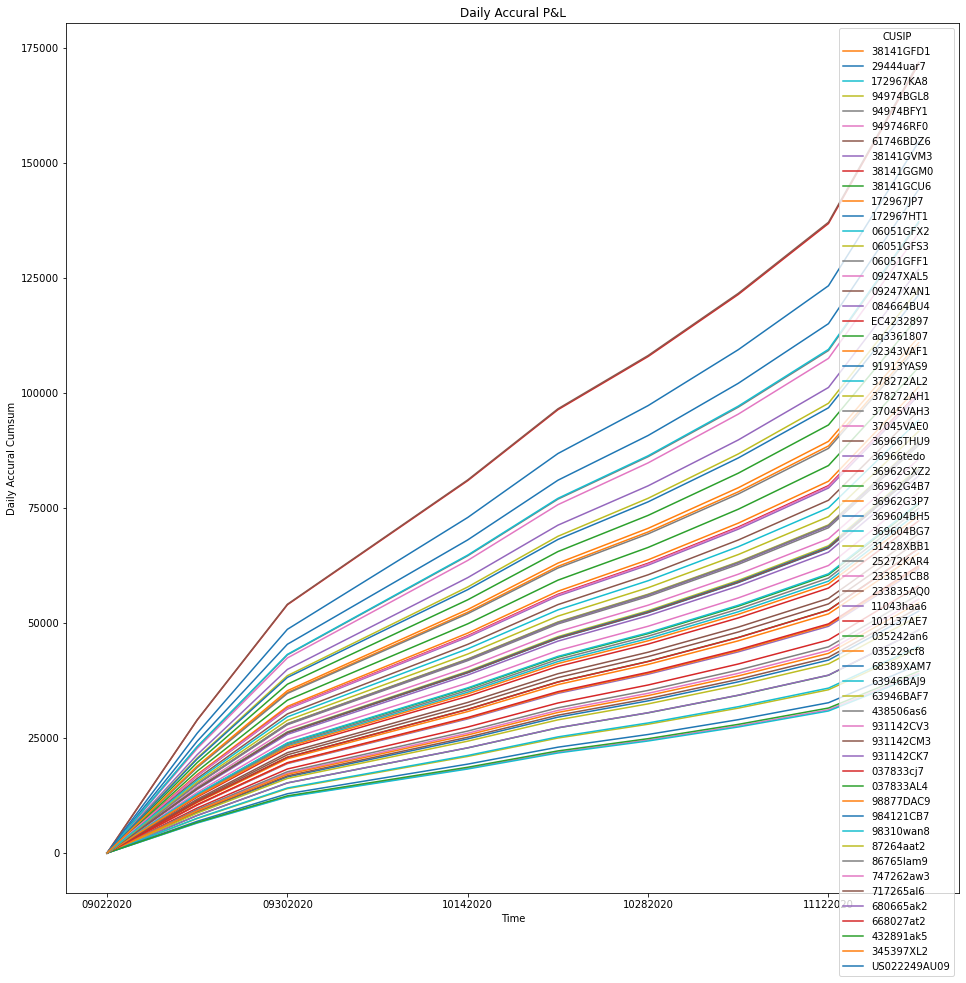

In [179]:
fig1, ax1 = plt.subplots(figsize=(16, 16))
# ["09022020","09172020","09302020","10072020","10142020","10222020","10282020","11042020","11122020","11302020"]
ax1.set(title="Daily Accural P&L",
        ylabel="Daily Accural Cumsum",
      xlabel="Time")
# ax1.legend(loc="upper left")
da.cumsum(axis=0).plot(ax=ax1,legend="reverse")

In [189]:
total_pnl=mtm+da.cumsum(axis=0)
total_pnl

CUSIP,US022249AU09,345397XL2,432891ak5,668027at2,680665ak2,717265al6,747262aw3,86765lam9,87264aat2,98310wan8,...,38141GCU6,38141GGM0,38141GVM3,61746BDZ6,949746RF0,94974BFY1,94974BGL8,172967KA8,29444uar7,38141GFD1
09022020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
09172020,-240797.546012,-86279.930441,-18273.421665,-127578.682346,-180415.852385,152918.398002,24707.962714,-155981.768293,-102201.765223,9465.721542,...,-8593.131071,-45308.187424,-17539.674323,-27596.764024,63344.315815,10680.422111,-37350.365100,-3126.954346,-18759.364471,-6266.000981
09302020,-421541.519053,-177709.077517,-63983.178616,47187.282950,-243039.348278,55699.427115,58888.005569,-266177.472241,-98505.010275,-60488.400135,...,-66499.237586,-263649.215144,-53239.188244,-97930.610269,-169884.793963,-49700.151061,-101281.740029,-55933.781696,-5334.104040,-256922.839154
10072020,-230126.155707,-25126.789964,43145.914864,-90702.897113,87261.407501,8896.464499,6686.010821,-171070.149455,-54204.133605,-44535.268190,...,15890.080718,-272584.921594,-50288.401859,-78767.496389,-199519.091315,22720.348503,-49168.403698,-30759.068761,17438.514564,-142471.727400
10142020,-49036.550592,84451.776876,93580.236164,51920.429444,311897.837301,186094.204171,15133.106337,-25875.893091,-31338.545412,140160.233675,...,96571.808257,-96715.034978,1005.267904,-48367.549995,-16273.277761,53064.679639,-2657.622132,6296.646110,24786.851332,-24022.470249
10222020,-41432.644949,66355.203467,95402.337772,52611.508606,318115.732643,257721.107014,42443.807787,-57958.335755,-30698.303821,183422.146518,...,25069.833105,-217249.025744,-3190.850362,-65929.017541,-185577.940615,36173.572508,-25666.404735,-32133.789009,36007.737493,-142622.917773
10282020,-95437.656615,-19810.777023,-72577.693284,-121122.809739,388267.954244,322816.891334,-10322.067391,-247288.201169,-77110.697259,193201.515588,...,493757.032680,438308.364807,137306.592207,-66225.484808,-125701.208473,85321.119312,6282.522950,-26777.366074,35011.395816,153542.222431
11042020,108463.665428,205253.588185,90714.054208,4720.717012,546889.826987,445440.978522,86773.698395,37612.318653,15730.735899,288483.345316,...,178904.981286,32884.191301,4411.175578,-13265.102476,-42954.107628,101185.262778,62274.551041,14680.302752,42542.268465,146570.666380
11122020,281279.702756,251018.530904,132493.392866,427412.574757,890720.631843,451447.819330,132684.120849,126153.159110,37022.610260,577065.878312,...,131413.823199,86437.263497,11783.140207,-16856.453924,42426.788454,70342.120719,9787.711059,29073.315089,49975.535122,149493.680242
11302020,452972.435842,400857.762386,213399.541733,515920.425466,894003.407019,289409.427570,283181.863383,315545.849151,9156.735239,784266.260480,...,239148.860870,313922.683382,34289.138055,17656.674515,496979.117281,214703.870137,150153.256210,123736.693824,70122.932845,415622.333170


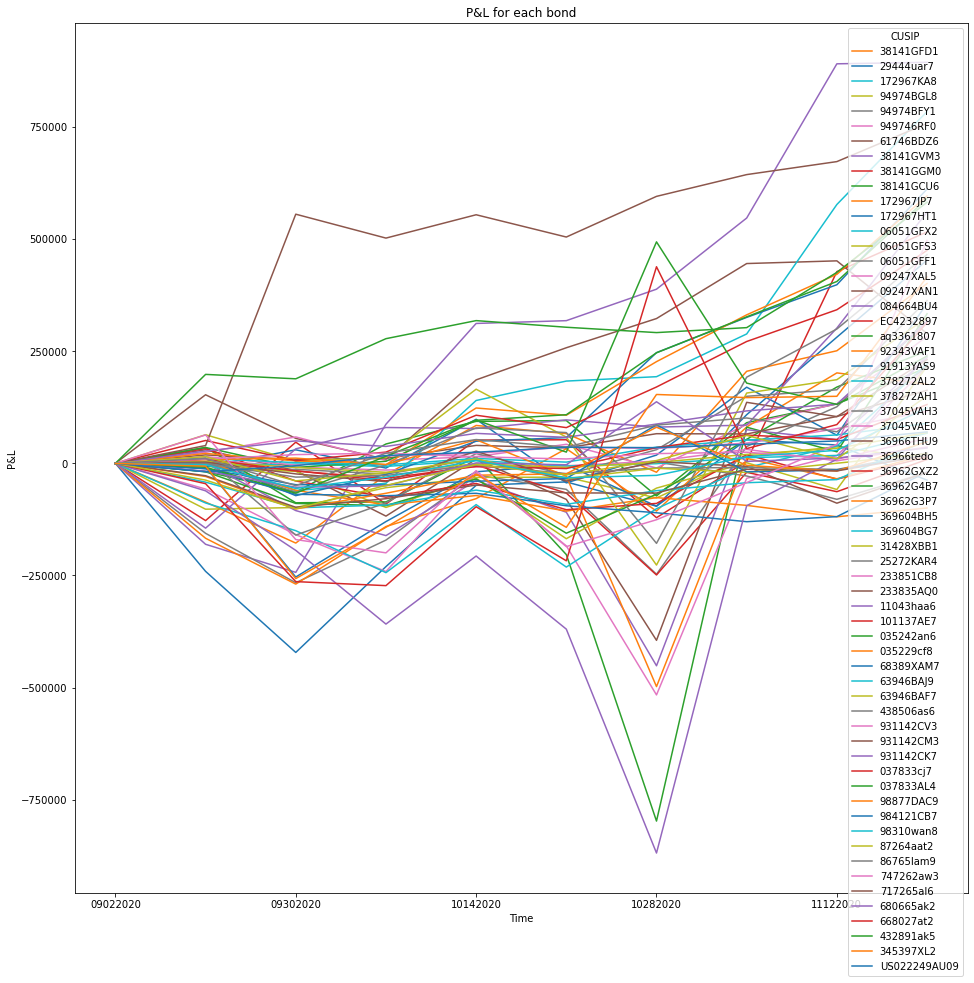

In [191]:
fig1, ax1 = plt.subplots(figsize=(16, 16))
# ["09022020","09172020","09302020","10072020","10142020","10222020","10282020","11042020","11122020","11302020"]
ax1.set(title="P&L for each bond",
        ylabel="P&L",
      xlabel="Time")
# ax1.legend(loc="upper left")
total_pnl.plot(ax=ax1,legend="reverse")

In [188]:
fig1, ax1 = plt.subplots(figsize=(16, 16))
# ["09022020","09172020","09302020","10072020","10142020","10222020","10282020","11042020","11122020","11302020"]
ax1.set(title="P&L for each bond",
        ylabel="P&L",
      xlabel="Time")
# ax1.legend(loc="upper left")
total_pnl.plot(ax=ax1,legend="reverse")

CUSIP,US022249AU09,345397XL2,432891ak5,668027at2,680665ak2,717265al6,747262aw3,86765lam9,87264aat2,98310wan8,...,38141GCU6,38141GGM0,38141GVM3,61746BDZ6,949746RF0,94974BFY1,94974BGL8,172967KA8,29444uar7,38141GFD1
09022020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
09172020,-265099.801262,-103347.651392,-37925.513131,-156477.226456,-201788.086604,123961.198572,1999.970000,-179050.185882,-122849.556543,-13655.730823,...,-26380.534859,-62173.951057,-32543.672889,-41606.650122,46522.514088,-4357.260120,-52793.304516,-18975.413164,-39199.580167,-25164.797506
09302020,-466905.728852,-209568.823293,-100667.082686,-6756.666055,-282934.185487,1645.988178,16499.752504,-309238.518407,-137047.554072,-103648.444550,...,-99702.391324,-295131.973926,-81246.652233,-124082.397654,-201285.490521,-77770.491226,-130108.560273,-85517.571489,-43489.173341,-292200.592666
10072020,-286831.417956,-64951.472184,-2708.965224,-158132.833370,37392.860990,-58670.334172,-46299.305510,-224896.457162,-102382.313352,-98485.323708,...,-25613.861455,-311938.370071,-85297.731846,-111457.230620,-238769.962011,-12367.576703,-85201.929003,-67738.806002,-30255.322062,-186568.919291
10142020,-117082.865290,36662.158212,38554.380058,-28995.494064,252055.581487,105014.045766,-48449.273261,-90467.462341,-89152.361109,75420.167053,...,46767.077650,-143939.173151,-41005.928080,-87595.231071,-63374.322597,10959.169392,-45897.852498,-38079.038579,-32445.752618,-76939.100518
10222020,-122440.162447,9462.800295,29895.366218,-43716.971761,246874.951912,161197.108913,-33249.501257,-134853.061051,-99524.274888,106350.638635,...,-34221.512856,-273468.237854,-53204.178914,-112628.637870,-241650.613039,-13952.034929,-77142.869456,-84961.985068,-32126.314829,-205618.906188
10282020,-186166.076212,-83530.268575,-145945.501425,-229010.707750,308478.279826,214710.013461,-95098.573521,-333410.293501,-154195.784854,106881.426758,...,427350.725203,375342.847243,81291.664229,-118529.059577,-188502.601588,29180.438983,-51371.117537,-85944.945659,-41298.742784,82986.715406
11042020,6394.193381,133569.160189,8175.270050,-116653.168250,457126.443267,323820.740914,-8599.871002,-59275.035221,-70989.987646,191373.245383,...,104197.885375,-37952.015958,-58605.618397,-72106.624091,-113605.674883,38026.997408,-2585.794507,-51883.224282,-43306.637461,67195.720976
11122020,166249.027910,170231.318401,39473.493259,290626.132636,789558.723206,314383.742026,25199.622006,16962.649189,-60710.268656,467624.337118,...,47220.111934,6605.982300,-59235.786337,-83169.914791,-37196.406388,-836.241841,-63308.868844,-45942.723314,-46774.819175,60039.376692
11302020,308779.054696,299589.284741,96797.132367,344455.730413,767194.817319,117596.710950,148447.773283,178673.238123,-113353.493261,647078.976447,...,133610.265060,213852.485825,-54734.586767,-65468.649671,397169.760366,125480.288900,58525.149006,29702.504840,-51155.680288,303489.473790


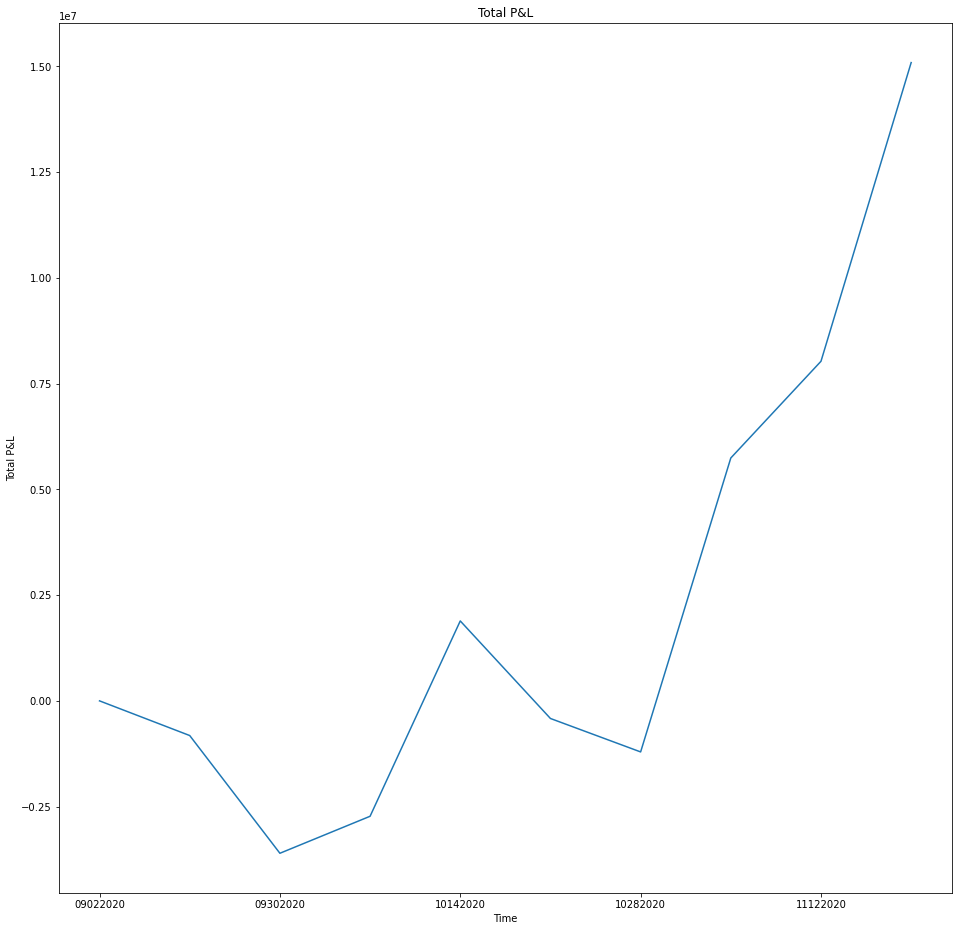

In [197]:
fig1, ax1 = plt.subplots(figsize=(16, 16))
# ["09022020","09172020","09302020","10072020","10142020","10222020","10282020","11042020","11122020","11302020"]
ax1.set(title="Total P&L",
        ylabel="Total P&L",
      xlabel="Time")
# ax1.legend(loc="upper left")
total_pnl.sum(axis=1).plot(ax=ax1)

In [198]:
total_pnl.to_excel("total_pnl.xlsx")

In [230]:
tpnl=pd.read_excel("total_pnl.xlsx",index_col=0)

In [231]:
tpnl

,US022249AU09,345397XL2,432891ak5,668027at2,680665ak2,717265al6,747262aw3,86765lam9,87264aat2,98310wan8,...,94974BFY1,94974BGL8,172967KA8,29444uar7,38141GFD1,912810FT0,084664BU4,035229cf8,HedgingSwap,TradingStrategy
9022020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.00,0.00,NaN,NaN
9172020,-240797.546012,-86279.930441,-18273.421665,-127578.682346,-180415.852385,152918.398002,24707.962714,-155981.768293,-102201.765223,9465.721542,...,10680.422111,-37350.365100,-3126.954346,-18759.364471,-6266.000981,866875,0.00,0.00,4.171008e+05,NaN
9302020,-421541.519053,-177709.077517,-63983.178616,47187.282950,-243039.348278,55699.427115,58888.005569,-266177.472241,-98505.010275,-60488.400135,...,-49700.151061,-101281.740029,-55933.781696,-5334.104040,-256922.839154,1733750,0.00,0.00,8.342016e+05,NaN
10072020,-230126.155707,-25126.789964,43145.914864,-90702.897113,87261.407501,8896.464499,6686.010821,-171070.149455,-54204.133605,-44535.268190,...,22720.348503,-49168.403698,-30759.068761,17438.514564,-142471.727400,2600625,-304536.76,0.00,1.251302e+06,NaN
10142020,-49036.550592,84451.776876,93580.236164,51920.429444,311897.837301,186094.204171,15133.106337,-25875.893091,-31338.545412,140160.233675,...,53064.679639,-2657.622132,6296.646110,24786.851332,-24022.470249,3467500,0.00,0.00,1.668403e+06,NaN
10222020,-41432.644949,66355.203467,95402.337772,52611.508606,318115.732643,257721.107014,42443.807787,-57958.335755,-30698.303821,183422.146518,...,36173.572508,-25666.404735,-32133.789009,36007.737493,-142622.917773,4334375,0.00,0.00,2.085504e+06,NaN
10282020,-95437.656615,-19810.777023,-72577.693284,-121122.809739,388267.954244,322816.891334,-10322.067391,-247288.201169,-77110.697259,193201.515588,...,85321.119312,6282.522950,-26777.366074,35011.395816,153542.222431,5201250,0.00,0.00,2.502605e+06,NaN
11042020,108463.665428,205253.588185,90714.054208,4720.717012,546889.826987,445440.978522,86773.698395,37612.318653,15730.735899,288483.345316,...,101185.262778,62274.551041,14680.302752,42542.268465,146570.666380,6068125,0.00,-72328.14,2.919706e+06,NaN
11122020,281279.702756,251018.530904,132493.392866,427412.574757,890720.631843,451447.819330,132684.120849,126153.159110,37022.610260,577065.878312,...,70342.120719,9787.711059,29073.315089,49975.535122,149493.680242,6935000,0.00,0.00,3.336806e+06,NaN
11302020,452972.435842,400857.762386,213399.541733,515920.425466,894003.407019,289409.427570,283181.863383,315545.849151,9156.735239,784266.260480,...,214703.870137,150153.256210,123736.693824,70122.932845,415622.333170,7801875,0.00,0.00,3.753907e+06,-278455.018684


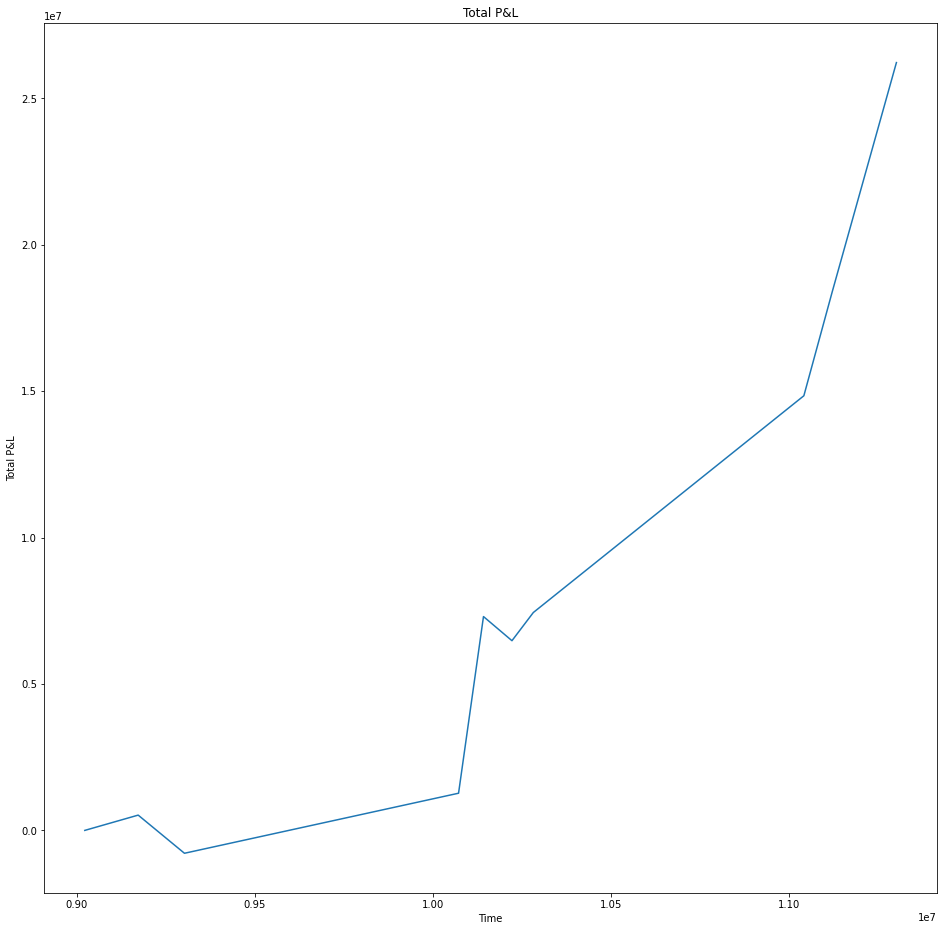

In [232]:
fig1, ax1 = plt.subplots(figsize=(16, 16))
# ["09022020","09172020","09302020","10072020","10142020","10222020","10282020","11042020","11122020","11302020"]
ax1.set(title="Total P&L",
        ylabel="Total P&L",
      xlabel="Time")
# ax1.legend(loc="upper left")
tpnl.sum(axis=1).plot(ax=ax1)

In [233]:
tpnl.sum(axis=1)

9022020     0.000000e+00
9172020     5.219652e+05
9302020    -7.811257e+05
10072020    1.270040e+06
10142020    7.303951e+06
10222020    6.479340e+06
10282020    7.441686e+06
11042020    1.484581e+07
11122020    1.841059e+07
11302020    2.622618e+07
dtype: float64

In [209]:
tpnl.

,9022020,9172020,9302020,10072020,10142020,10222020,10282020,11042020,11122020,11302020
US022249AU09,0.0,-240797.546012,-421541.519053,-230126.155707,-49036.550592,-41432.644949,-95437.656615,108463.665428,281279.702756,4.529724e+05
345397XL2,0.0,-86279.930441,-177709.077517,-25126.789964,84451.776876,66355.203467,-19810.777023,205253.588185,251018.530904,4.008578e+05
432891ak5,0.0,-18273.421665,-63983.178616,43145.914864,93580.236164,95402.337772,-72577.693284,90714.054208,132493.392866,2.133995e+05
668027at2,0.0,-127578.682346,47187.282950,-90702.897113,51920.429444,52611.508606,-121122.809739,4720.717012,427412.574757,5.159204e+05
680665ak2,0.0,-180415.852385,-243039.348278,87261.407501,311897.837301,318115.732643,388267.954244,546889.826987,890720.631843,8.940034e+05
...,...,...,...,...,...,...,...,...,...,...
94974BGL8,0.0,-37350.365100,-101281.740029,-49168.403698,-2657.622132,-25666.404735,6282.522950,62274.551041,9787.711059,1.501533e+05
172967KA8,0.0,-3126.954346,-55933.781696,-30759.068761,6296.646110,-32133.789009,-26777.366074,14680.302752,29073.315089,1.237367e+05
29444uar7,0.0,-18759.364471,-5334.104040,17438.514564,24786.851332,36007.737493,35011.395816,42542.268465,49975.535122,7.012293e+04
38141GFD1,0.0,-6266.000981,-256922.839154,-142471.727400,-24022.470249,-142622.917773,153542.222431,146570.666380,149493.680242,4.156223e+05


In [210]:
da

CUSIP,US022249AU09,345397XL2,432891ak5,668027at2,680665ak2,717265al6,747262aw3,86765lam9,87264aat2,98310wan8,...,38141GCU6,38141GGM0,38141GVM3,61746BDZ6,949746RF0,94974BFY1,94974BGL8,172967KA8,29444uar7,38141GFD1
09022020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
09172020,24302.255249,17067.720951,19652.091466,28898.544110,21372.234219,28957.199430,22707.992713,23068.417589,20647.791320,23121.452365,...,17787.403788,16865.763633,15003.998566,14009.886099,16821.801727,15037.682231,15442.939416,15848.458818,20440.215697,18898.796525
09302020,21061.954549,14792.024825,17031.812604,25045.404895,18522.602990,25096.239506,19680.260352,19992.628577,17894.752477,20038.592050,...,15415.749950,14616.995149,13003.465424,12141.901286,14578.894830,13032.657934,13383.880827,13735.330975,17714.853604,16378.956988
10072020,11341.052450,7964.936444,9170.976018,13485.987251,9973.709302,13513.359734,10597.063266,10765.261542,9635.635949,10790.011104,...,8300.788435,7870.689695,7001.865997,6537.946846,7850.174139,7017.585041,7206.705061,7395.947448,9538.767325,8819.438378
10142020,11341.052450,7964.936444,9170.976018,13485.987251,9973.709302,13513.359734,10597.063266,10765.261542,9635.635949,10790.011104,...,8300.788435,7870.689695,7001.865997,6537.946846,7850.174139,7017.585041,7206.705061,7395.947448,9538.767325,8819.438378
10222020,12961.202800,9102.784507,10481.115449,15412.556859,11398.524917,15443.839696,12110.929447,12303.156047,11012.155371,12331.441261,...,9486.615354,8995.073938,8002.132568,7471.939253,8971.627588,8020.097190,8236.234355,8452.511369,10901.448372,10079.358146
10282020,9720.902100,6827.088381,7860.836587,11559.417644,8548.893688,11582.879772,9083.197085,9227.367036,8259.116528,9248.580946,...,7114.961515,6746.305453,6001.599426,5603.954439,6728.720691,6015.072892,6177.175767,6339.383527,8176.086279,7559.518610
11042020,11341.052450,7964.936444,9170.976018,13485.987251,9973.709302,13513.359734,10597.063266,10765.261542,9635.635949,10790.011104,...,8300.788435,7870.689695,7001.865997,6537.946846,7850.174139,7017.585041,7206.705061,7395.947448,9538.767325,8819.438378
11122020,12961.202800,9102.784507,10481.115449,15412.556859,11398.524917,15443.839696,12110.929447,12303.156047,11012.155371,12331.441261,...,9486.615354,8995.073938,8002.132568,7471.939253,8971.627588,8020.097190,8236.234355,8452.511369,10901.448372,10079.358146
11302020,29162.706299,20481.265142,23582.509760,34678.252932,25646.681063,34748.639316,27249.591256,27682.101107,24777.349584,27745.742838,...,21344.884546,20238.916360,18004.798279,16811.863318,20186.162073,18045.218677,18531.527300,19018.150581,24528.258836,22678.555830


In [213]:
da.cumsum(axis=0).sum(axis=1)

09022020    0.000000e+00
09172020    8.910673e+05
09302020    1.663326e+06
10072020    2.079157e+06
10142020    2.494988e+06
10222020    2.970224e+06
10282020    3.326651e+06
11042020    3.742482e+06
11122020    4.217718e+06
11302020    5.286999e+06
dtype: float64

In [216]:
mtm.sum(axis=1)

09022020    0.000000e+00
09172020   -1.710938e+06
09302020   -5.266479e+06
10072020   -4.807502e+06
10142020   -6.052799e+05
10222020   -3.386815e+06
10282020   -4.533895e+06
11042020    1.999708e+06
11122020    3.811083e+06
11302020    9.803748e+06
dtype: float64

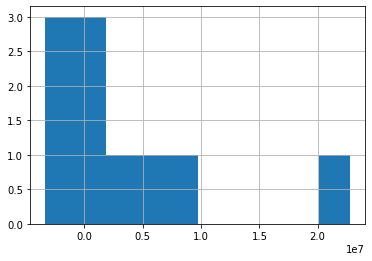

In [218]:
tpnl.sum(axis=1)

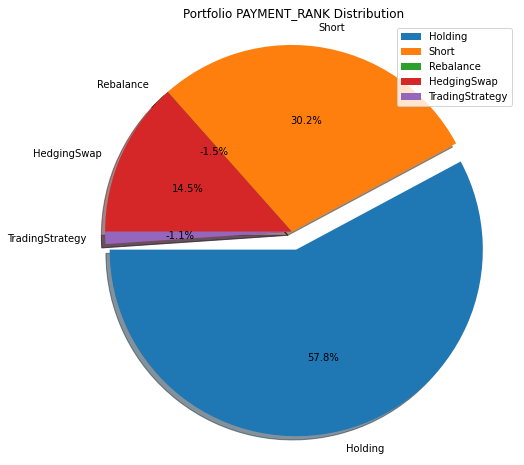

In [220]:
labels,sizes=["Holding","Short","Rebalance","HedgingSwap","TradingStrategy"],[14948855.54,7801875,-376864.9,3753907.199,-278455.0187]
fig1, ax1 = plt.subplots(figsize=(8, 8))
explode=np.zeros(len(sizes))
explode[np.argmax(sizes)]=0.1
ax1.pie(sizes,  labels=labels,explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=180)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set(title="Portfolio P&L Distribution")
ax1.legend()
plt.show()